# Package Installation and load the data

In [ ]:
!pip install numpy pandas matplotlib networkx seaborn umap-learn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import networkx as nx
import networkx.algorithms.bipartite as bipartite
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [ ]:
#load the data
df = pd.read_excel('../portfolio data.xlsx')

In [ ]:
# Get the descriptive stats for count of awards per year
year_counts = df['Year awarded'].value_counts().sort_index()

plt.figure(figsize=(10, 6))

plt.bar(year_counts.index.astype(str), year_counts.values, color='skyblue', label='Counts')
plt.plot(year_counts.index.astype(str), year_counts.values, color='red', marker='o', label='Trend')

plt.xlabel('Year Awarded')
plt.ylabel('Counts')
plt.title('Study Design Awarded Project Trend')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#Network analysis - project interconnectedness & topic identification

In [ ]:
df['Methods Topics'] = df['Methods Topics'].str.split('; ')
df = df.explode('Methods Topics').reset_index(drop=True)

df = df[['Contract Number', 'Methods Topics']]
df["Methods Topics"] = df["Methods Topics"].str.lower()

In [ ]:
contract_numbers = df['Contract Number'].unique()
methods_topics = df['Methods Topics'].unique()

In [ ]:
G=nx.from_pandas_edgelist(df, 'Contract Number', 'Methods Topics', create_using=nx.Graph())

df_me = pd.DataFrame({
    'ID': list(contract_numbers) + list(methods_topics),
    'type': ['project'] * len(contract_numbers) + ['topic'] * len(methods_topics)
})


degrees = dict(G.degree())
df_me= df_me.set_index('ID')
df_me=df_me.reindex(G.nodes())

df_me['type']=pd.Categorical(df_me['type'])
df_me['type'].cat.codes

cmap = matplotlib.colors.ListedColormap(['red', 'blue'])

node_sizes = [200 * degrees[node] if df_me.loc[node]['type'] == 'topic' else 100*degrees[node] for node in G.nodes()]


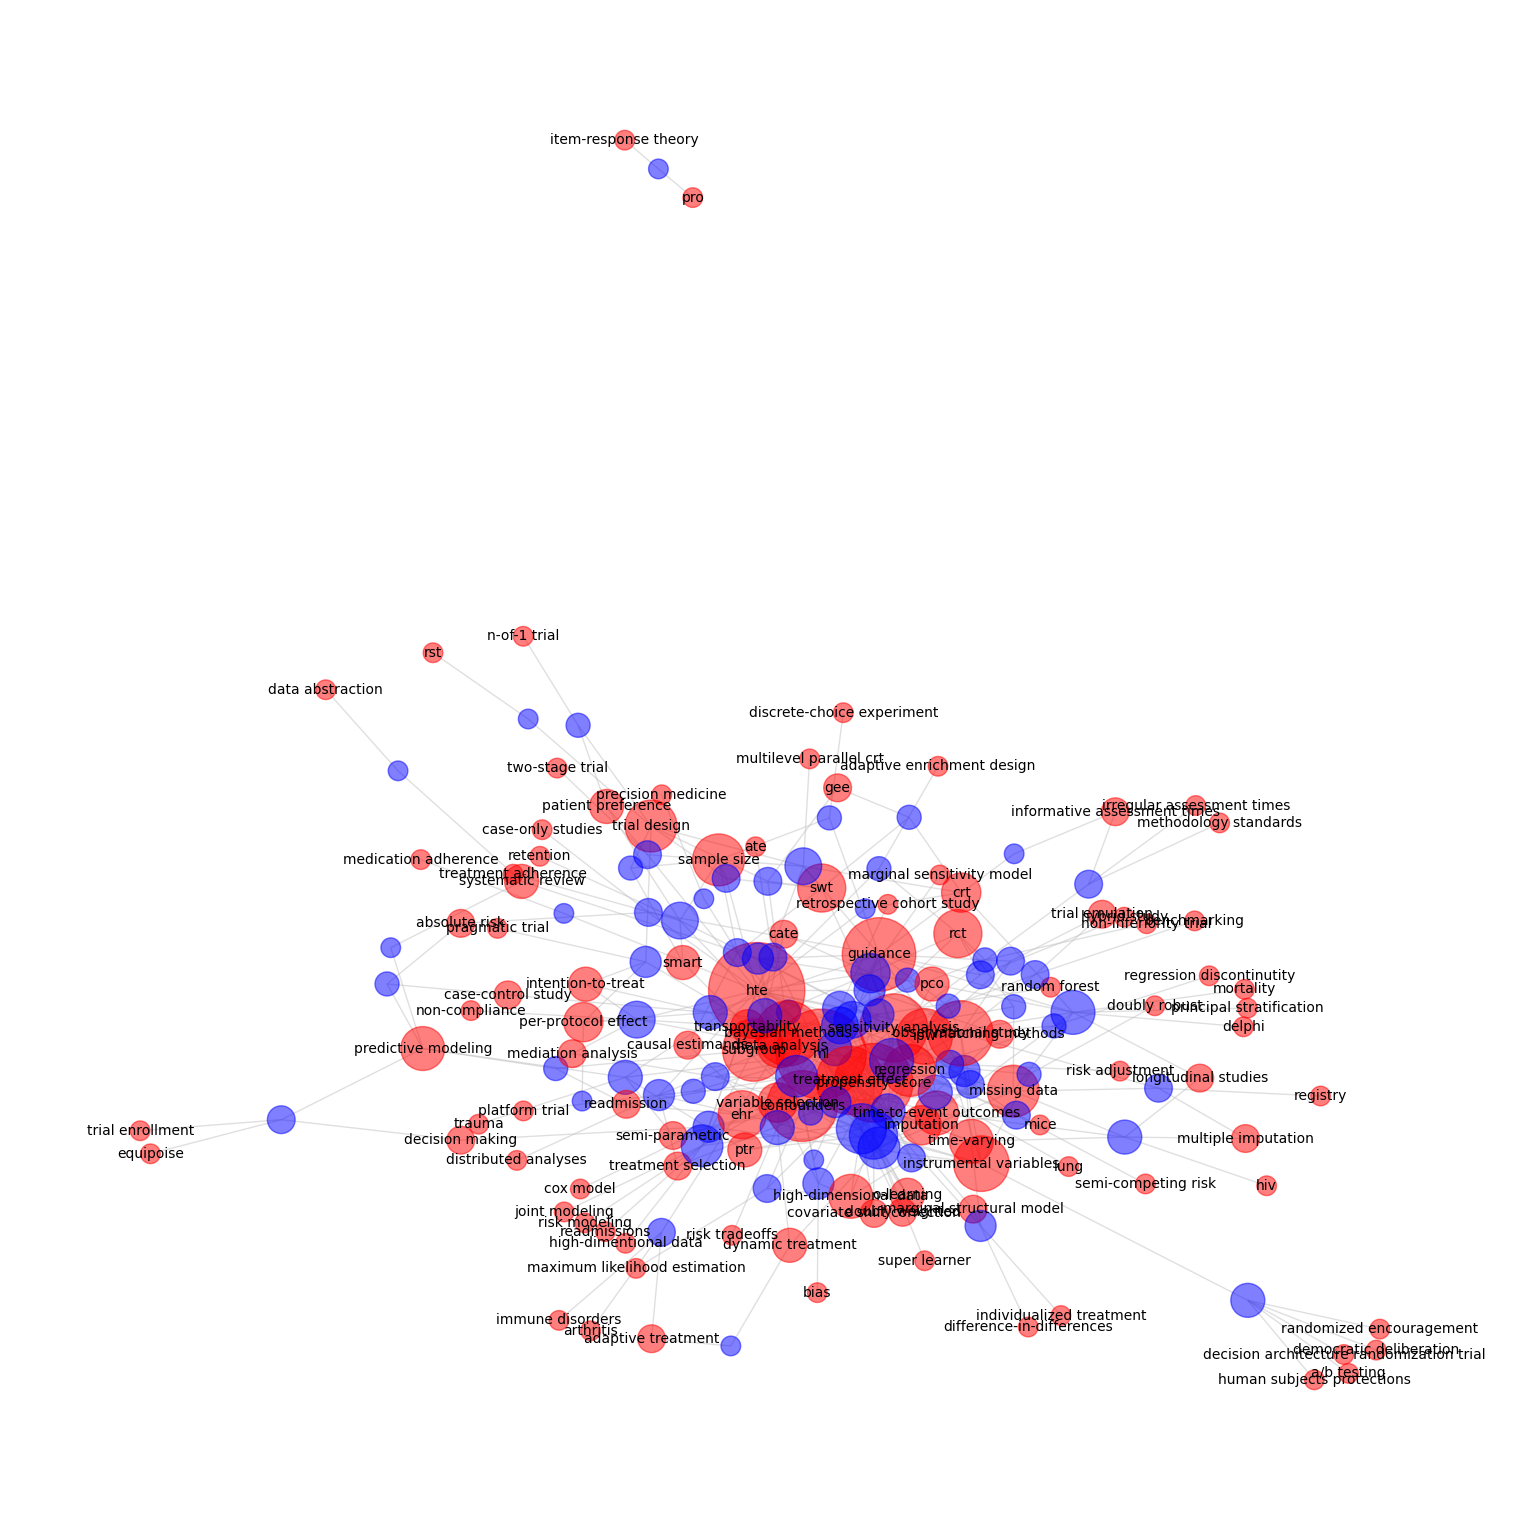

In [ ]:
plt.figure(1,figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=False, node_color=df_me['type'].cat.codes, cmap=cmap, font_color='black', font_weight='bold',font_size = 7,
        node_size=node_sizes, edge_color='silver', alpha=0.5)

measure_nodes = [node for node in G.nodes() if df_me.loc[node]['type'] == 'topic']
measure_labels = {node: node if node in measure_nodes else '' for node in G.nodes()}
nx.draw_networkx_labels(G, pos=pos, labels=measure_labels, font_size=10, font_color='black')

plt.show()

In [14]:
unique_projects_per_keyword = df.groupby(['Methods Topics'])['Contract Number'].nunique()
unique_projects_per_keyword_df = unique_projects_per_keyword.reset_index()
unique_projects_per_keyword_df.columns = ['Methods Topics','unique_projects_count']
unique_projects_per_keyword_df_sorted = unique_projects_per_keyword_df.sort_values('unique_projects_count', ascending=False)

In [15]:
unique_projects_per_keyword_df_sorted

,Methods Topics,unique_projects_count
35,hte,24
60,ml,21
78,propensity score,16
31,guidance,14
13,confounders,13
...,...,...
100,super learner,1
106,trauma,1
107,treatment adherence,1
112,trial enrollment,1


#Remove topical keywords that only appeared once

In [16]:
filter_topic = unique_projects_per_keyword_df_sorted[unique_projects_per_keyword_df['unique_projects_count'] > 1]
unique_keyword = filter_topic['Methods Topics'].unique()

/tmp/ipython-input-16-2322848557.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filter_topic = unique_projects_per_keyword_df_sorted[unique_projects_per_keyword_df['unique_projects_count'] > 1]


In [21]:
filter_topic_df = df[df['Methods Topics'].isin(unique_keyword)]

In [22]:
contract_numbers_filter = filter_topic_df['Contract Number'].unique()
methods_topics_filter = filter_topic_df['Methods Topics'].unique()

In [25]:
G=nx.from_pandas_edgelist(filter_topic_df, 'Contract Number', 'Methods Topics', create_using=nx.Graph())

df_me_filter = pd.DataFrame({
    'ID': list(contract_numbers_filter) + list(methods_topics_filter),
    'type': ['project'] * len(contract_numbers_filter) + ['topic'] * len(methods_topics_filter)
})

degrees = dict(G.degree())
df_me_filter= df_me_filter.set_index('ID')
df_me_filter=df_me_filter.reindex(G.nodes())

df_me_filter['type']=pd.Categorical(df_me_filter['type'])
df_me_filter['type'].cat.codes

cmap = matplotlib.colors.ListedColormap(['blue', 'red'])
node_sizes = [300 * degrees[node] if df_me_filter.loc[node]['type'] == 'topic' else 100*degrees[node] for node in G.nodes()]


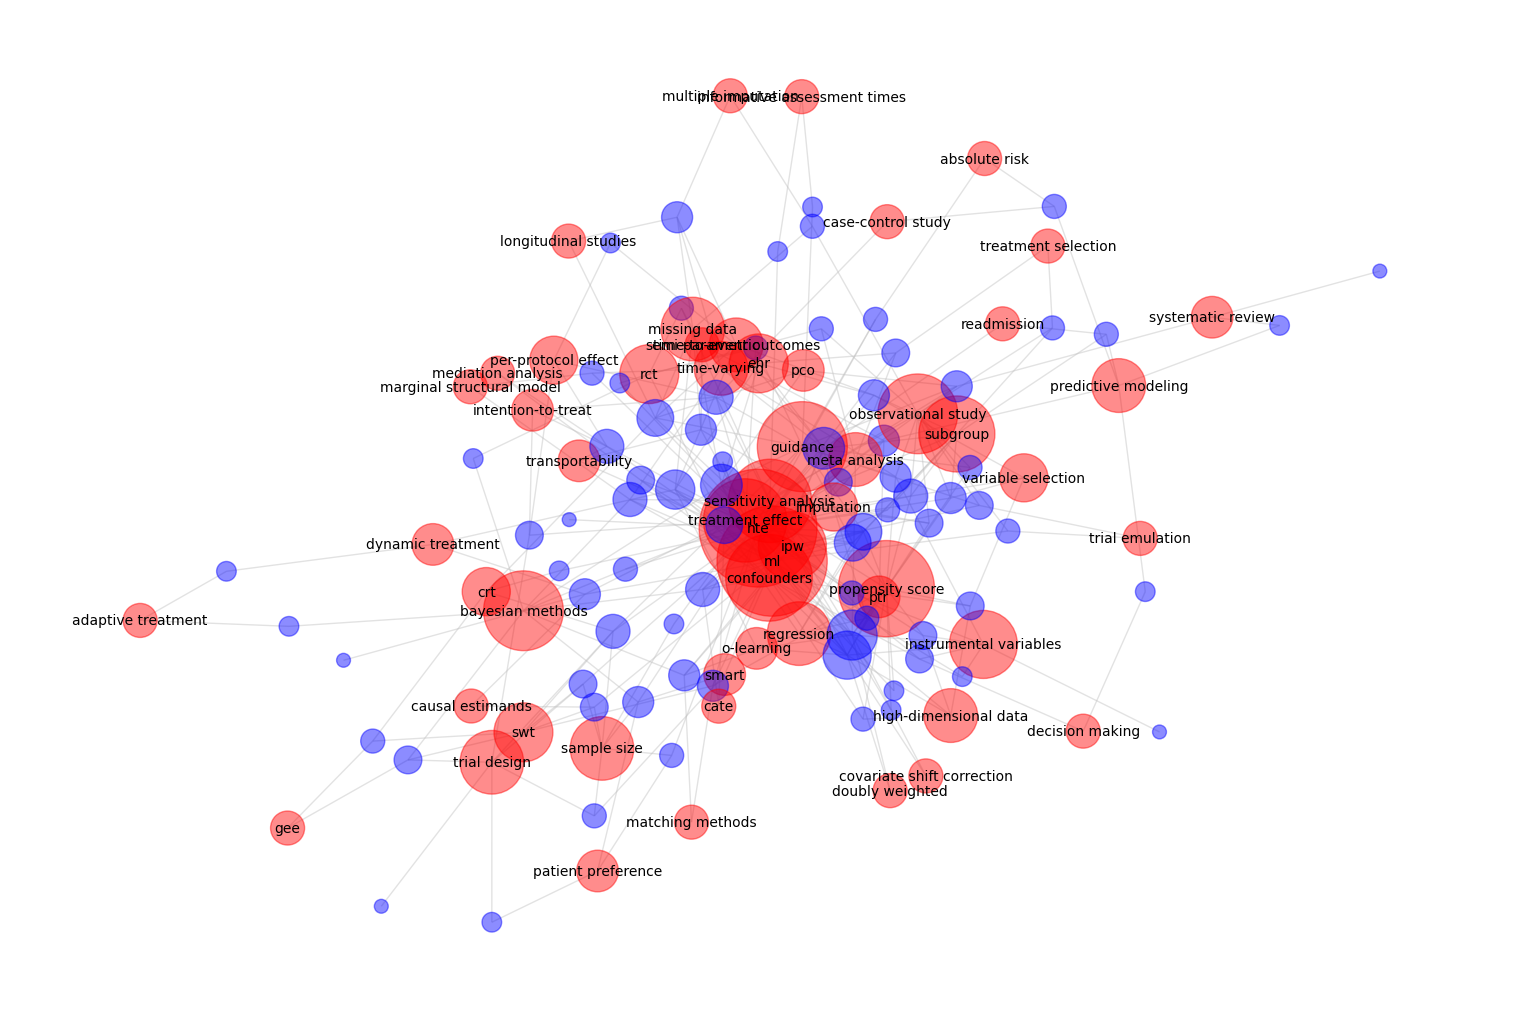

In [26]:
plt.figure(1,figsize=(15,10))
pos = nx.spring_layout(G) #kamada_kawai_
nx.draw(G, pos=pos, with_labels=False, node_color=df_me_filter['type'].cat.codes, cmap=cmap, font_color='black', font_weight='bold',font_size=6,
        node_size=node_sizes, edge_color='silver', alpha=0.45)

# Display labels for nodes labeled as 'measure'
measure_nodes = [node for node in G.nodes() if df_me_filter.loc[node]['type'] == 'topic']
measure_labels = {node: node if node in measure_nodes else '' for node in G.nodes()}
nx.draw_networkx_labels(G, pos=pos, labels=measure_labels, font_size=10, font_color='black')

plt.show()

# Thematic cluster - using 'confounders' as an example

In [ ]:
project, topic = bipartite.sets(G)
print ("\nProject:\n" + str(list(project)))
print ("\nTopic:\n" + str(list(topic)))

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


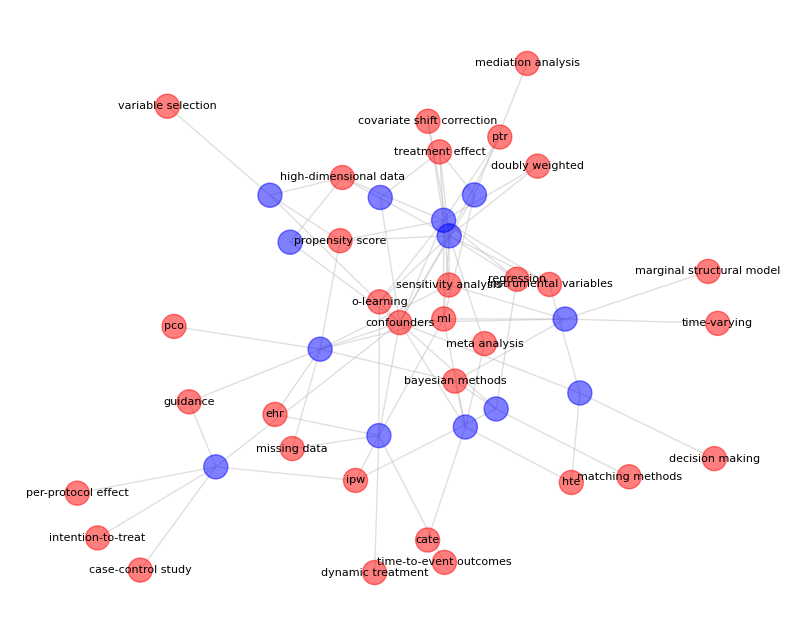

In [41]:
# Extract the clusters of projects on topic 'confounders' and the co-occurring topics
confounders_cluster = nx.Graph(nx.ego_graph(G, 'confounders', radius=2))

plt.figure(2, figsize=(10, 8))
colors = ['red' if node in topic else 'blue' for node in confounders_cluster.nodes()]

pos = nx.spring_layout(confounders_cluster, seed=42)

nx.draw_networkx_nodes(confounders_cluster, pos, node_color=colors, cmap=cmap, alpha=0.5)
nx.draw_networkx_edges(confounders_cluster, pos, edge_color='silver', alpha=0.5)

red_labels = {node: node for node in confounders_cluster.nodes() if node in topic}

# Draw labels only for red nodes
nx.draw_networkx_labels(confounders_cluster, pos, labels=red_labels, font_color='black', font_size=8)

plt.axis('off')
plt.show()

# Network analysis - topic evolution

In [43]:
hsv_modified = cm.get_cmap('hsv', 256)# create new hsv colormaps in range of 0.3 (green) to 0.7 (blue)
newcmp = ListedColormap(hsv_modified(np.linspace(0.3, 0.7, 256)))# show figure

/tmp/ipython-input-43-1367435827.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  hsv_modified = cm.get_cmap('hsv', 256)# create new hsv colormaps in range of 0.3 (green) to 0.7 (blue)


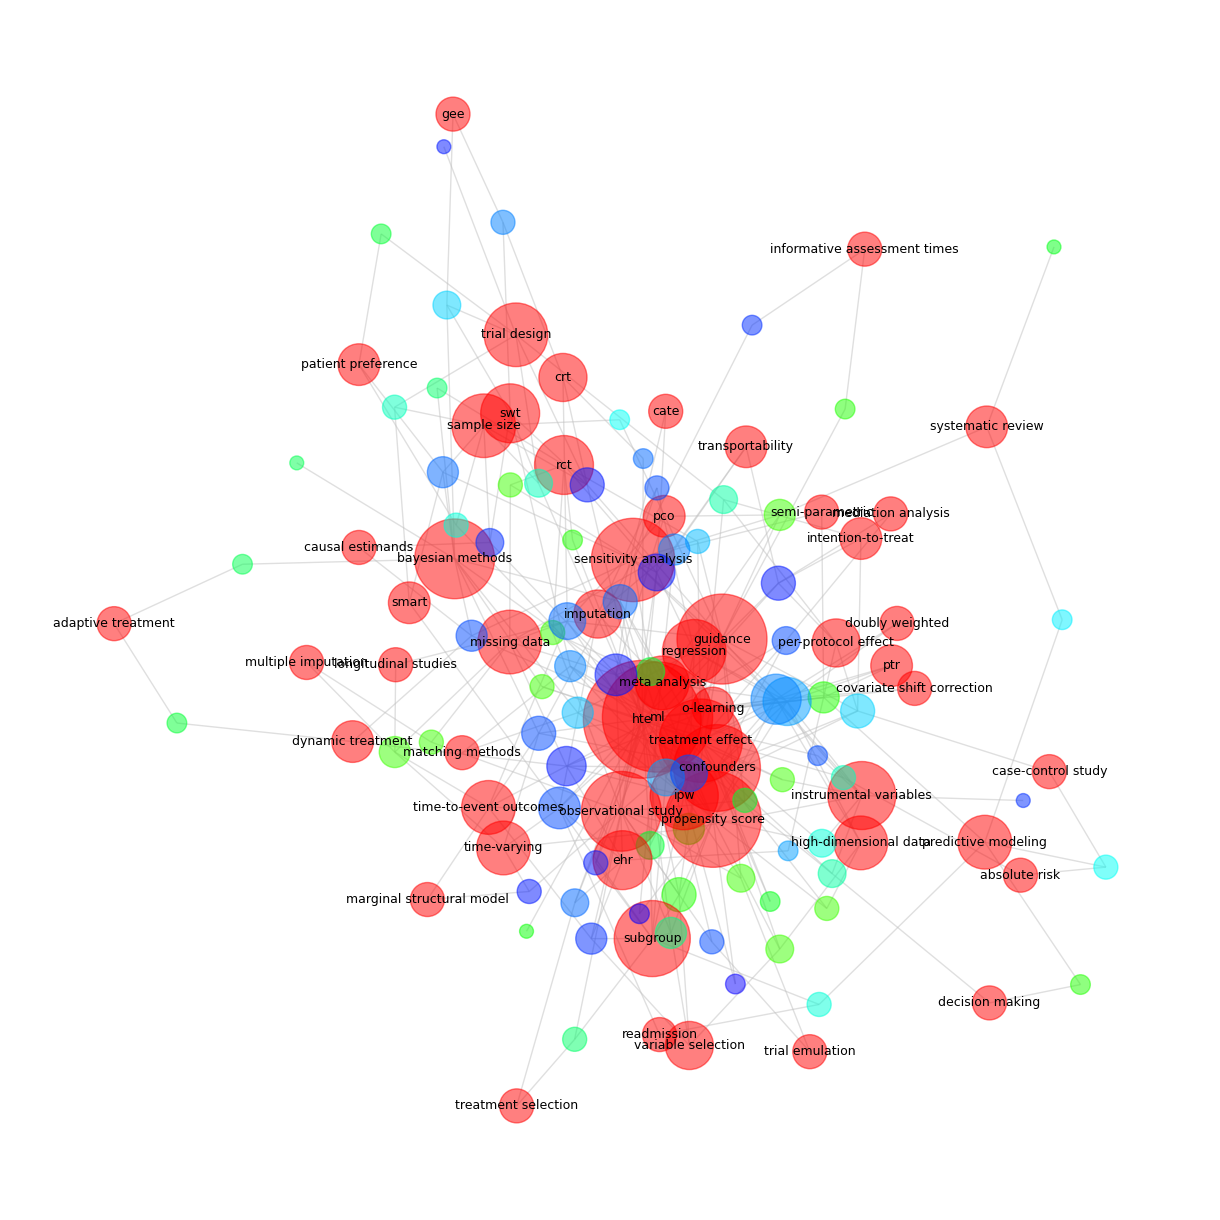

In [46]:

G = nx.from_pandas_edgelist(filter_topic_df, 'Contract Number', 'Methods Topics', create_using=nx.Graph())

df_me_filter = pd.DataFrame({
    'ID': list(contract_numbers_filter) + list(methods_topics_filter),
    'type': ['project'] * len(contract_numbers_filter) + ['topic'] * len(methods_topics_filter)
})

df_me_filter = df_me_filter.set_index('ID')
df_me_filter = df_me_filter.reindex(G.nodes())
df_me_filter['type'] = pd.Categorical(df_me_filter['type'])

# Extract years from project IDs
def extract_year(id_str):
    if id_str.startswith("ME-"):  # Check if ID starts with a year format
        return int(id_str.split('-')[1][:4])
    return None  # Return None for non-projects

df_me_filter['year'] = df_me_filter.index.map(extract_year)

# Define colormap for projects by year
unique_years = sorted(df_me_filter['year'].dropna().unique())
color_map =ListedColormap(hsv_modified(np.linspace(0.3, 0.7, 256)))
year_to_color = {year: color_map(i / len(unique_years)) for i, year in enumerate(unique_years)}

# Assign colors: red for "measure", varying colors for "projects"
node_colors = [year_to_color[df_me_filter.loc[node, 'year']] if df_me_filter.loc[node, 'type'] == 'project' else 'red' for node in G.nodes()]

degrees = dict(G.degree())
node_sizes = [300 * degrees[node] if df_me_filter.loc[node]['type'] == 'topic' else 100*degrees[node] for node in G.nodes()]

# Plot the graph
plt.figure(1, figsize=(12, 12))
pos = nx.spring_layout(G)

nx.draw(G, pos=pos, with_labels=False, node_color=node_colors, font_color='black', font_size=5.5,
        node_size=node_sizes, edge_color='silver', alpha=0.5) #viridis

measure_nodes = [node for node in G.nodes() if df_me_filter.loc[node]['type'] == 'topic']
measure_labels = {node: node for node in measure_nodes}
nx.draw_networkx_labels(G, pos=pos, labels=measure_labels, font_size=9, font_color='black')

plt.show()


# Thematic clustering

In [ ]:
# network focused on topic - co-occurrance of topics among these projects
project, topic = bipartite.sets(G)
topicDegree = nx.degree(G, topic)
projectDegree = nx.degree(G, project)
W = bipartite.projected_graph(G, topic)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


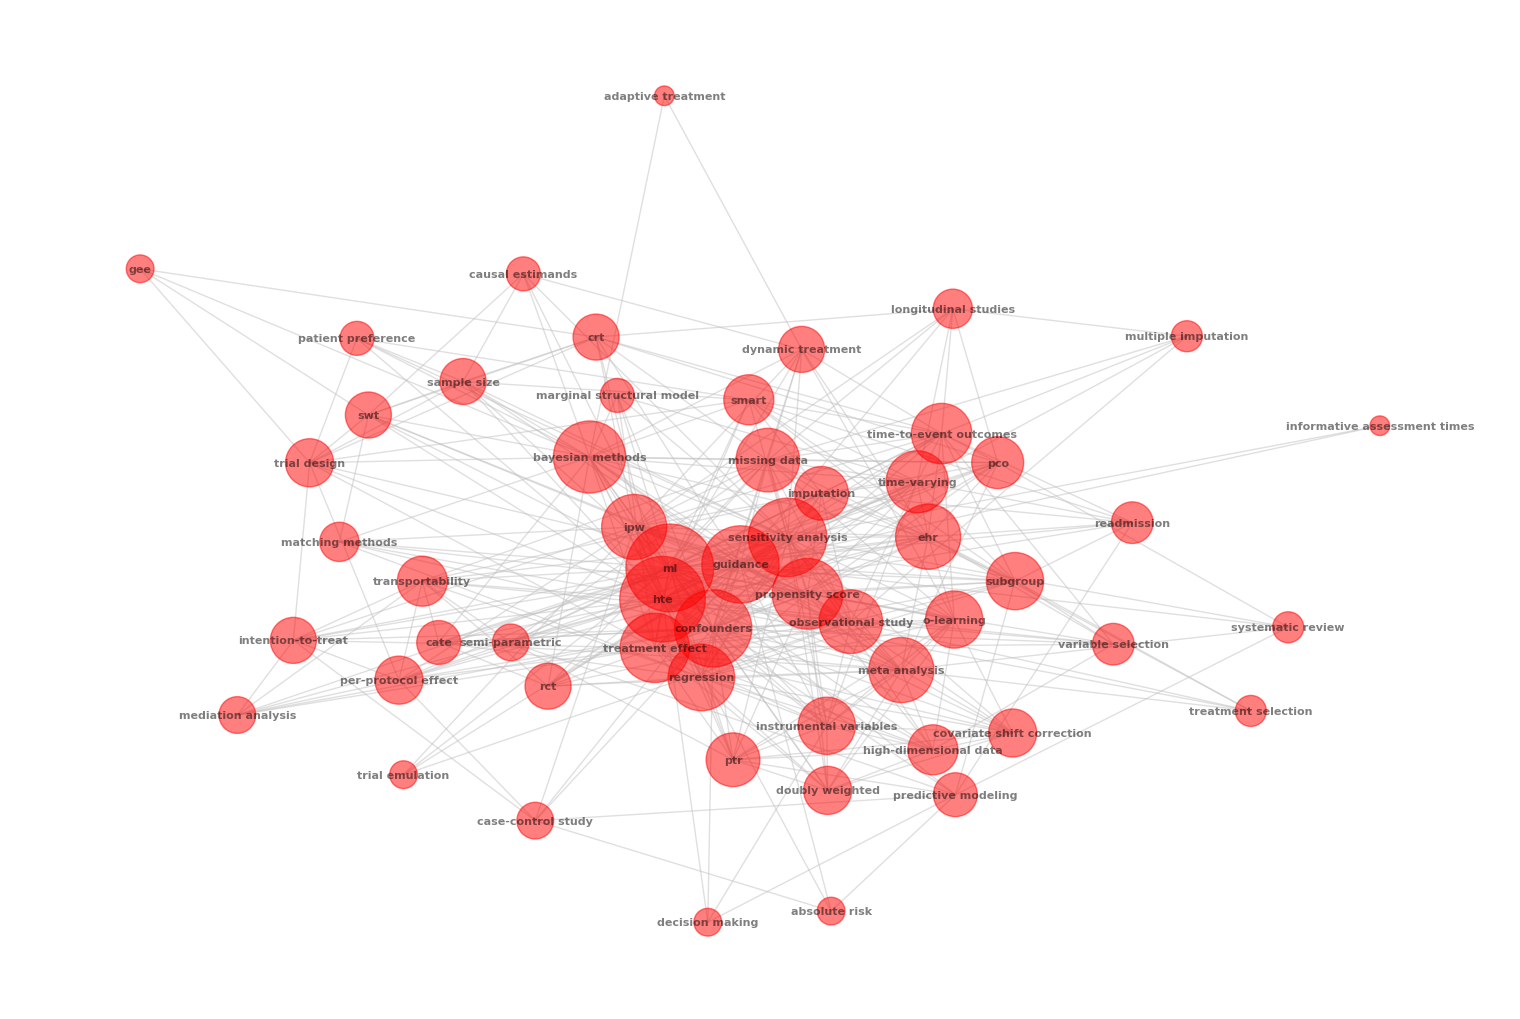

In [51]:
plt.figure(2,figsize=(15,10))
node_sizes = [100 * W.degree[node] for node in W.nodes()]

nx.draw_spring(W, with_labels=True, node_color='red', cmap=cmap, font_color='black', font_weight='bold',font_size=8,
        node_size=node_sizes, edge_color='silver', alpha=0.5)